<a href="https://colab.research.google.com/github/ashimashahi15/BioInformatics/blob/main/nn_for_sequence_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Sequence Data

In this notebook I want to demonstrate how easy it is to train a Neural Network (NN) on DNA data,
make predictions for Transcription Factor Binding Sites (TFBS) and extract the learned motif with a simple gradient-based method.

In [7]:
# Clone the GitHub repository
!git clone https://github.com/const-ae/Neural_Network_DNA_Demo

# Navigate to the directory where the Python files are located
import os
os.chdir("Neural_Network_DNA_Demo")

# Import the modules
from helper import IOHelper, SequenceHelper
import motif_plotter

# Now you can use the imported modules in your Colab notebook


Cloning into 'Neural_Network_DNA_Demo'...
remote: Enumerating objects: 56, done.
remote: Total 56 (delta 0), reused 0 (delta 0), pack-reused 56
Receiving objects: 100% (56/56), 3.28 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (24/24), done.


## Load Necessary Libraries

In [11]:
# Install Keras
!pip install keras

# Import necessary libraries
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
import numpy as np





The provided code is written in Python and it demonstrates the implementation of a Convolutional Neural Network (CNN) for predicting whether a given DNA sequence is bound by a transcription factor or not. Here's a breakdown of the code:

1. Import necessary libraries: The code imports required libraries such as scikit-learn for evaluating the model, helper for handling input/output and sequence operations, random for shuffling data, motif_plotter for visualizing the learned motif, and matplotlib.pyplot for plotting.

2.Set random seed: The random seed is set for reproducibility of results.
Load sequence data: The code loads DNA sequence data from a FASTA file (data/pu1.fa.gz). The sequences are read and converted to a one-hot encoded matrix using the SequenceHelper.do_one_hot_encoding function.

3.Dinucleotide shuffling: A helper function do_dinucleotide_shuffling is defined to generate negative data by shuffling the positive data (DNA sequences bound by the transcription factor). This is done by randomly rearranging the dinucleotides (pairs of nucleotides) in the sequences.

4.Generate negative data: The do_dinucleotide_shuffling function is used to generate negative data (shuffled sequences) from the positive data. The shuffled sequences are then one-hot encoded.

5.Create CNN architecture: A Sequential CNN model is created using the Keras library. The model consists of a 2D convolutional layer with 16 filters of size (12, 4), followed by a max pooling layer, a flatten layer, and two dense layers with 32 and 1 neuron(s), respectively. The output of the last dense layer is passed through a sigmoid activation function, making it a binary classification problem.

6. Prepare data for training: The positive and negative data are combined, shuffled, and split into training and test sets. The input data is reshaped to match the expected input shape of the CNN model.

7. Train the model: The CNN model is trained using the fit method, with the training data and validation data specified.

8. Evaluate the model: After training, the model is evaluated on the test set. The code calculates the predictions, Area Under the Receiver Operating Characteristic Curve (AUC), and Average Precision Score (AUPRC).


9. Visualize the learned motif: The code selects a subset of the positive data (5 sequences) and makes predictions on these sequences using the trained model. It then calculates the gradient of the model output with respect to the input sequences to identify the most important positions in the sequences (motif). Finally, the learned motif is visualized using the motif_plotter.make_single_sequence_spectrum function.

this code demonstrates how to build and train a CNN model to identify DNA sequences bound by a specific transcription factor, using dinucleotide shuffling to generate negative data. It also shows how to evaluate the model's performance and visualize the learned motif, which can provide insights into the sequence patterns recognized by the model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 89, 1, 16)         784       
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 1, 16)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 32)                2592      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3409 (13.32 KB)
Trainable params: 3409 (13.32 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

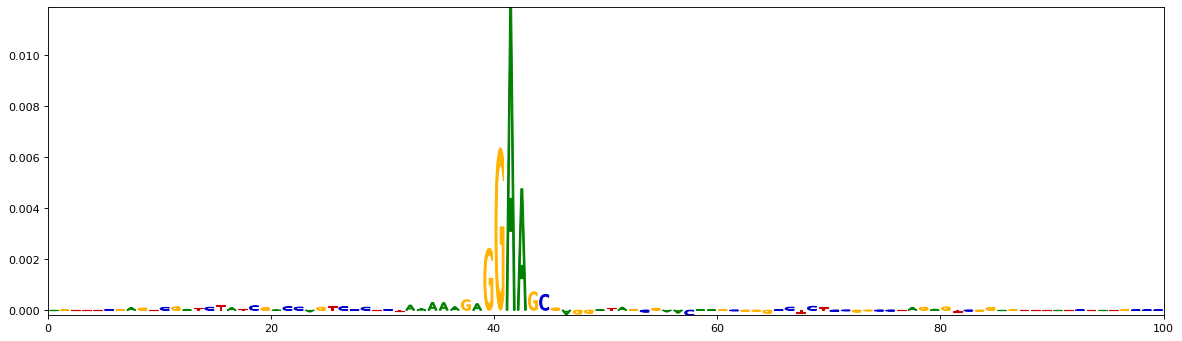

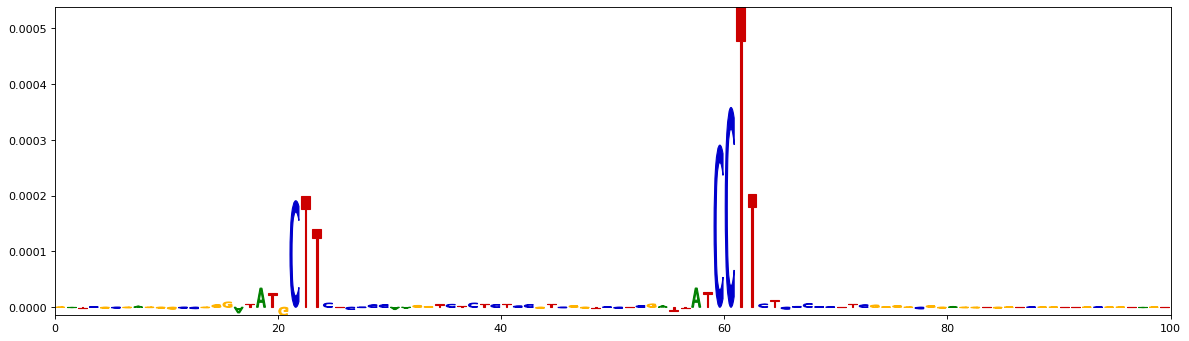

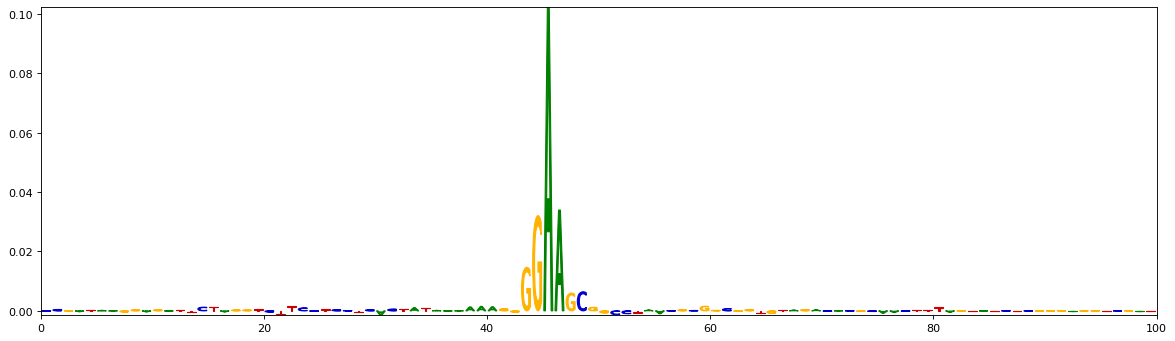

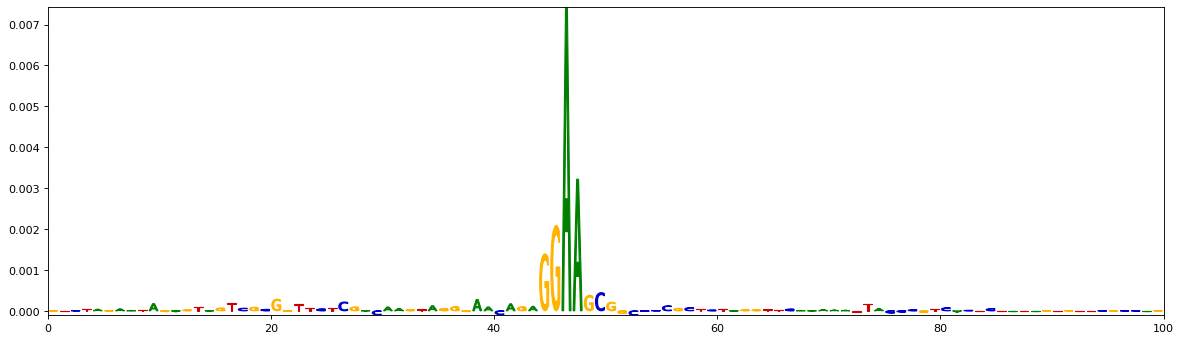

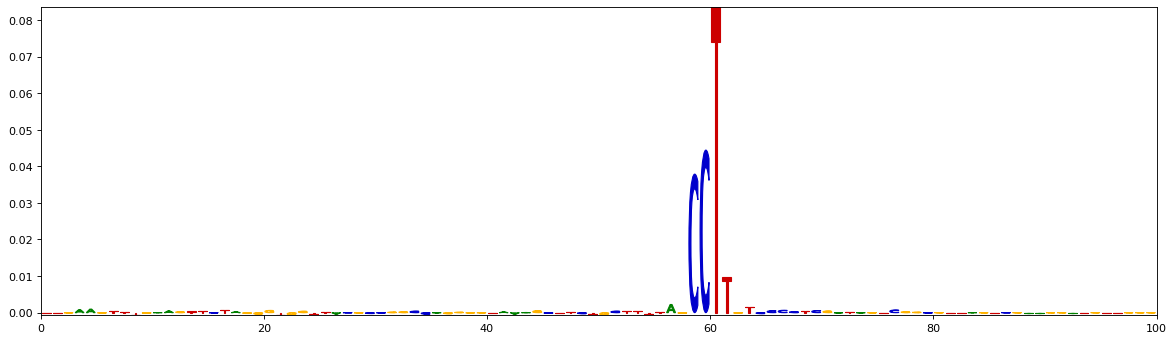

In [12]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc, average_precision_score
from helper import IOHelper, SequenceHelper
import random
import motif_plotter
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(1234)

# Load sequence data
input_fasta_data = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_fasta_data.sequence[0])
seq_matrix = SequenceHelper.do_one_hot_encoding(input_fasta_data.sequence, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

# Helper function for dinucleotide shuffling
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)
    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]
    return x_shuffled

# Generate negative data by shuffling positive data
seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_fasta_data.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
seq_shuffled_matrix = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                         SequenceHelper.parse_alpha_to_seq)

# Create the Neural Network Architecture
model = Sequential()
model.add(Conv2D(16, (12, 4), padding='valid', input_shape=(100, 4, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(15,1), padding='valid'))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()

# Create a test and a training subset
shuffling_index = np.arange(seq_matrix.shape[0] + seq_shuffled_matrix.shape[0])
np.random.shuffle(shuffling_index)
X = np.concatenate((seq_matrix, seq_shuffled_matrix))[shuffling_index, :, :]
X = np.nan_to_num(X)
Y = np.concatenate((np.ones(seq_matrix.shape[0]), np.zeros(seq_shuffled_matrix.shape[0])))[shuffling_index]
X_train = X[0:int(X.shape[0]*0.8), :, :]
Y_train = Y[0:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):X.shape[0], :, :]
Y_test = Y[int(X.shape[0]*0.8):X.shape[0]]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# Fit the Model
model.fit(X_train_reshaped, Y_train, batch_size=10, epochs=25, validation_data=(X_test_reshaped, Y_test))

# Evaluating the Model
pred = model.predict(X_test_reshaped, batch_size=32).flatten()
print("Predictions", pred[0:5])
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

# Make a motif plot
plot_index = range(0, 5)
seq_matrix_for_plotting = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2], 1))[plot_index, :]
plotting_pred = model.predict(seq_matrix_for_plotting, batch_size=32).flatten()

# Calculate Gradient
tmp = np.repeat(seq_matrix_for_plotting, 100, axis=0)
a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), seq_matrix_for_plotting.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 100, 1, 1)), 4, axis=2))
d_pred = model.predict(d, batch_size=32).flatten()
scores = np.reshape((np.repeat(plotting_pred, 100) - d_pred), (len(plot_index),100))

# Make the Actual Plot
for idx in range(0,len(plot_index)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax,
                                                seq_matrix_for_plotting[idx].reshape((100, 4)),
                                                np.arcsinh(scores[idx]).reshape(100,1))
    plt.show()


The provided output shows the results obtained after training and evaluating the convolutional neural network (CNN) model on the DNA sequence data. Let's break down the different parts of the output:



1. First section shows the architecture of the CNN model, including the layers and their output shapes, as well as the number of trainable parameters. The model consists of a convolutional layer with 16 filters, a max pooling layer, a flatten layer, and two dense layers with 32 and 1 neuron(s), respectively.

2. Training section displays the training progress over 25 epochs. For each epoch, it shows the loss on the training data (loss) and the loss on the validation data (val_loss). The loss values decrease over the epochs, indicating that the model is learning to distinguish between sequences bound by the transcription factor and those that are not.

3. Predictions:
The trained model is making predictions on a subset of the test data. The output shows the predicted probabilities for the first five samples, where values closer to 1 indicate that the sequence is predicted to be bound by the transcription factor, and values closer to 0 indicate that the sequence is not bound

4. Evaluation Metrics:
The code evaluates the model's performance using two metrics:

AUC (Area Under the Receiver Operating Characteristic Curve): This metric measures the ability of the model to distinguish between positive and negative examples. An AUC value of 0.9848 (on a scale of 0 to 1) indicates that the model has excellent discrimination power.
AUPRC (Area Under the Precision-Recall Curve): This metric evaluates the trade-off between precision and recall for the model. An AUPRC value of 0.9839 suggests that the model has a high precision and recall for predicting transcription factor binding sites.

Both the AUC and AUPRC values are close to 1, indicating that the trained CNN model performs well in predicting whether a DNA sequence is bound by the transcription factor or not.

The provided images show the visualizations of the learned motifs by the convolutional neural network (CNN) model for predicting transcription factor binding sites in DNA sequences.

Image 1:
This image displays the learned motif pattern for a particular DNA sequence. The x-axis represents the position along the DNA sequence (from 0 to 100), and the y-axis shows the importance scores assigned by the model to each position.
The prominent peaks in the plot indicate the positions that the model has identified as most important for determining whether the sequence is bound by the transcription factor or not. The highest peak is around position 40, suggesting that this region of the sequence is most crucial for the binding of the transcription factor.

Image 2:
This image appears to be a zoomed-in version of the motif pattern shown in Image 1, focusing on the region with the highest importance scores. The y-axis scale is different, but the peak positions remain the same.
In this zoomed view, we can observe the specific patterns of nucleotide preferences learned by the model at the most important positions. The red and blue spikes likely represent the model's preference for certain nucleotides (e.g., adenine or thymine) at those positions, while the yellow and green spikes suggest preferences for other nucleotides (e.g., cytosine or guanine).

Image 3:
This image shows the learned motif pattern for another DNA sequence. The overall shape of the motif is similar to the one in Image 1, with a prominent peak around position 40, indicating the region most important for transcription factor binding.
However, the specific patterns of nucleotide preferences within the peak region may differ slightly from the previous sequence, as the model has learned to recognize slightly different motif patterns across different sequences.
The visualization of these learned motifs provides insights into the sequence patterns that the CNN model has identified as crucial for transcription factor binding. By analyzing these motifs, researchers can better understand the sequence-level features that the model is using to make its predictions, which can lead to further biological insights and potentially identify new transcription factor binding sites in the genome.